<a href="https://colab.research.google.com/github/jhyoo78/jhyoo78/blob/main/notebooks/inference-dynamic-resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook shows how to run inference with the [MAXIM family of models](https://github.com/google-research/maxim) from [TensorFlow Hub](https://tfhub.dev/sayakpaul/collections/maxim/1). MAXIM family of models share the same backbone for performing: denoising, dehazing, deblurring, deraining, and enhancement. You can know more about the public MAXIM models from [here](https://github.com/google-research/maxim#results-and-pre-trained-models).

This notebook allows you to run dynamic shaped images unlike [this one](https://github.com/sayakpaul/maxim-tf/blob/main/notebooks/inference.ipynb).

## Select a checkpoint

In [1]:
task = "Enhancement"  # @param ["Denoising", "Dehazing_Indoor", "Dehazing_Outdoor", "Deblurring", "Deraining", "Enhancement", "Retouching"]

model_handle_map = {
    "Denoising": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_denoising_sidd/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Denoising/input/0003_30.png",
    ],
    "Dehazing_Indoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-indoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/0003_0.8_0.2.png",
    ],
    "Dehazing_Outdoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-outdoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/1444_10.png",
    ],
    "Deblurring": [
        "https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_gopro/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deblurring/input/1fromGOPR0950.png",
    ],
    "Deraining": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_deraining_raindrop/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deraining/input/15.png",
    ],
    "Enhancement": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
    "Retouching": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_fivek/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
}

model_handle = model_handle_map[task]
ckpt = model_handle[0]
print(f"TF-Hub handle: {ckpt}.")

TF-Hub handle: https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1.


For deblurring, there are other checkpoints too:

- https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_realblur_r/1
- https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_realblur_j/1
- https://tfhub.dev/sayakpaul/maxim_s-3_deblurring_reds/1


## Imports

In [2]:
import tensorflow as tf
import tensorflow_hub as hub    # Tensorflow Hub에 저장된 모델을 불러올 때 필요함
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

In [3]:
# MAXIM git code 설치

#!pip install git+https://github.com/google-research/maxim

# /content/maxim-tf 디렉토리가 생성되고 그 안에 github에 있는 코드가 설치된다.
!git clone https://github.com/sayakpaul/maxim-tf.git/    #Python project가 아니라서 pip 으로 설치 불가

#!python3 /content/maxim-tf/create_maxim_model.py   # Model() 정의
#!python3 /content/maxim-tf/maxim/configs.py        # MAXIM_CONFIGS 정의됨

fatal: destination path 'maxim-tf' already exists and is not an empty directory.


In [81]:
import sys   # 파이썬 인터프리터 제어 기능을 제공
import os

sys.path.append("/content/maxim-tf")   # --> 파이썬의 모든 경로가 저장된 sys.path list에 추가할 디렉토리 지정

from create_maxim_model import Model       #  https://github.com/sayakpaul/maxim-tf/tree/main 에 있음
from maxim.configs import MAXIM_CONFIGS

TODO: When the repository is public, clone it and use accordingly.

## Fetch the input image based on the task

/root/.keras/datasets/a4541-DSC_0040-2.png


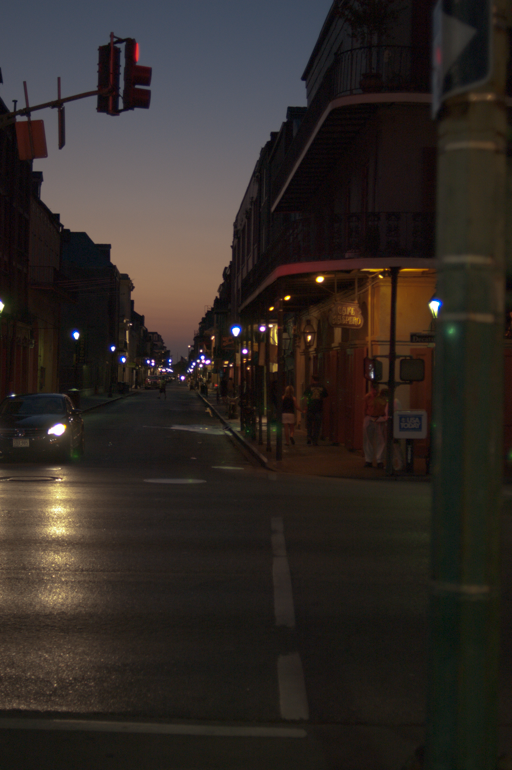

In [76]:
image_url = model_handle[1]     # 사용할 이이지의 url을 첫번쨰 cell에서 정의하고 있음
image_path = tf.keras.utils.get_file(origin=image_url)
print(image_path)
Image.open(image_path)

## Load the model( 1분 소요)

In [77]:
# _MODEL = tf.keras.models.load_model(ckpt)  # Keras model을 가져올 때,,,, Kera model은 https를 지원하지 않으며, local file path를 지우너하고 있음. Keras 모델은  predict(), fir() 등을 사용할 수 있음.
_MODEL = hub.load(ckpt)  # Tensor Hub에 저장된 모델을 가져 올 때...

## Preprocessing utilities

Based on [this official script](https://github.com/google-research/maxim/blob/main/maxim/run_eval.py).

In [82]:
def mod_padding_symmetric(image, factor=64):
    """Padding the image to be divided by factor."""
    height, width = image.shape[0], image.shape[1]
    height_pad, width_pad = ((height + factor) // factor) * factor, (
        (width + factor) // factor
    ) * factor
    padh = height_pad - height if height % factor != 0 else 0
    padw = width_pad - width if width % factor != 0 else 0
    image = tf.pad(
        image, [(padh // 2, padh // 2), (padw // 2, padw // 2), (0, 0)], mode="REFLECT"
    )
    return image


def make_shape_even(image):
    """Pad the image to have even shapes."""
    height, width = image.shape[0], image.shape[1]
    padh = 1 if height % 2 != 0 else 0
    padw = 1 if width % 2 != 0 else 0
    image = tf.pad(image, [(0, padh), (0, padw), (0, 0)], mode="REFLECT")
    return image


def process_image(image: Image):
    input_img = np.asarray(image) / 255.0
    height, width = input_img.shape[0], input_img.shape[1]

    # Padding images to have even shapes
    input_img = make_shape_even(input_img)
    height_even, width_even = input_img.shape[0], input_img.shape[1]

    # padding images to be multiplies of 64
    input_img = mod_padding_symmetric(input_img, factor=64)
    input_img = tf.expand_dims(input_img, axis=0)
    return input_img, height, width, height_even, width_even


def init_new_model(input_img):
    variant = ckpt.split("/")[-1].split("_")[0]
    configs = MAXIM_CONFIGS.get(variant) or MAXIM_CONFIGS.get("S-2")  ####

    #print("variant=". variant)   # --> "1"
    print("configs=", configs)   # --> 'None'

    if configs is None:  # Added a check to raise an error if no config is found ###
        raise ValueError(f"No configuration found for variant: {variant}")       ###

    print("KK1")
    configs.update(
        {
            "variant": "S-2",
            "dropout_rate": 0.0,
            "num_outputs": 3,
            "use_bias": True,
            "num_supervision_scales": 3,
        }
    )  # From https://github.com/google-research/maxim/blob/main/maxim/run_eval.py#L45-#L61

    print("KK2")
    configs.update({"input_resolution": (input_img.shape[1], input_img.shape[2])})
    print("KK3")

    new_model = Model(**configs)  ## ---> error 발생
    print("KK4")
    new_model.set_weights(_MODEL.get_weights())
    print("KK5")
    return new_model


To make the model operate on images of arbitrary shapes here's what we're doing:

* Loading the initial pre-trained model into `_MODEL`.
* Initializing a separate instance of MAXIM based on the configs and spatial resolutions of the input image.
* Populating the params of this newly initialized model with that of `_MODEL`.

All of it is handled in `init_new_model()`.

## Run predictions

In [83]:
# Based on https://github.com/google-research/maxim/blob/main/maxim/run_eval.py

def infer(image_path: str):
    #print(image_path)  # 출력 --> /root/.keras/datasets/a4541-DSC_0040-2.png
    image = Image.open(image_path).convert("RGB")
    print("OK1")
    preprocessed_image, height, width, height_even, width_even = process_image(image)
    print("OK2")
    #print("preprocess=", preprocessed_image) ## 추가

    new_model = init_new_model(preprocessed_image)  # init_new_model() 호출==> 오류 발생
    print("OK3")
    print("new_model=", new_model) #### 추가

    preds = new_model.predict(preprocessed_image)
    print("OK4")
    if isinstance(preds, list):
        preds = preds[-1]
        if isinstance(preds, list):
            preds = preds[-1]

    preds = np.array(preds[0], np.float32)
    print("OK5")
    new_height, new_width = preds.shape[0], preds.shape[1]
    h_start = new_height // 2 - height_even // 2
    h_end = h_start + height
    w_start = new_width // 2 - width_even // 2
    w_end = w_start + width
    preds = preds[h_start:h_end, w_start:w_end, :]

    print(np.array(np.clip(preds, 0.0, 1.0)))

    return np.array(np.clip(preds, 0.0, 1.0))

In [84]:
final_pred_image = infer(image_path)  # image_path="/root/.keras/datasets/a4541-DSC_0040-2.png"

OK1
OK2
configs= {'features': 32, 'depth': 3, 'num_stages': 2, 'num_groups': 2, 'num_bottleneck_blocks': 2, 'block_gmlp_factor': 2, 'grid_gmlp_factor': 2, 'input_proj_factor': 2, 'channels_reduction': 4, 'name': 's2', 'variant': 'S-2', 'dropout_rate': 0.0, 'num_outputs': 3, 'use_bias': True, 'num_supervision_scales': 3, 'input_resolution': (832, 512)}
KK1
KK2
KK3


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


## Visualize results

NameError: name 'final_pred_image' is not defined

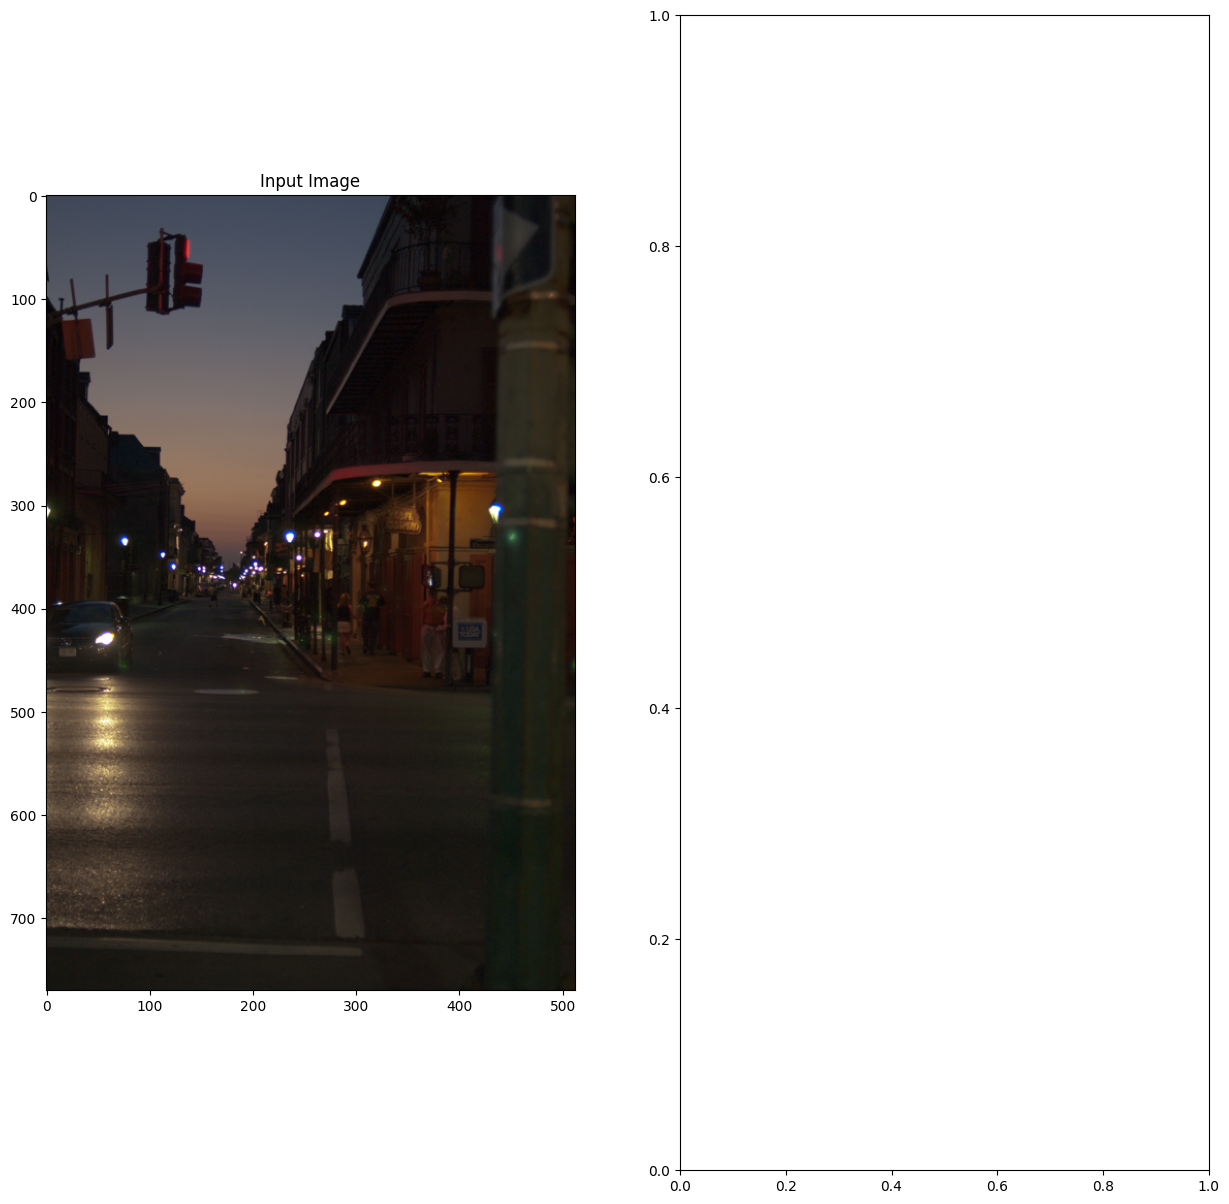

In [13]:
# Based on https://www.tensorflow.org/lite/examples/style_transfer/overview#visualize_the_inputs
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
input_image = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
imshow(input_image, "Input Image")

plt.subplot(1, 2, 2)
imshow(final_pred_image, "Predicted Image")